## 1. Problem Statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

## 2. Import Dependencies and Load Data

In [111]:
import pandas as pd
import numpy as np
import re
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, make_scorer
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

import statsmodels.api as sm

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Load data from following files ::
1. Train data :: train.csv. Contains both dependent and independent features. So for model creation we will create train and test data from this file.
2. Test or unseen data :: test.csv. Contains only independent variables. Will use our model to predict the solution using this unseen data.
3. Data Dictionary :: data_dictionary

In [3]:
data = pd.read_csv("train.csv")
unseen_data = pd.read_csv("test.csv")
data_dict = pd.read_csv("data_dictionary.csv")
sample = pd.read_csv("sample.csv")

In [4]:
data.shape

(69999, 172)

In [5]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/14,7/31/14,8/31/14,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/14,7/31/14,8/31/14,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/14,7/31/14,8/31/14,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/14,7/31/14,8/31/14,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/14,7/31/14,8/31/14,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [6]:
data_dict.head()

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls


There are multiple acronyms have been used in the dataset. Using regular expressions to filter important columns from the dataset.

In [7]:
average_revenue = [i for i in list(data.columns) if re.search('arpu_[678]',i)]
onnet_monthly_usage = [i for i in list(data.columns) if re.search('onnet_mou_[678]',i)]
offnet_monthly_usage = [i for i in list(data.columns) if re.search('offnet_mou_[678]',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
total_incoming_minutes = [i for i in list(data.columns) if re.search('total.+ic.+mou',i)]
total_recharge_number = [i for i in list(data.columns) if re.search('total.+rech.+num_[678]',i)]
total_recharge_amount = [i for i in list(data.columns) if re.search('total.+rech.+amt_[678]',i)]
max_recharge_amount = [i for i in list(data.columns) if re.search('max.+rech.+amt_[678]',i)]
total_recharge_data = [i for i in list(data.columns) if re.search('total.+rech.+data[678]',i)]
max_recharge_data = [i for i in list(data.columns) if re.search('max.+rech.+data[678]',i)]
volume_of_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_of_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]
social_user = [i for i in list(data.columns) if re.search('fb.+user',i)]

ids = ['id','circle_id']

# Creating new variable with all the columns
columns = [*ids, *average_revenue, *onnet_monthly_usage, *offnet_monthly_usage, *total_outgoing_minutes,
          *total_incoming_minutes, *total_recharge_number, *total_recharge_amount, *max_recharge_amount, *total_recharge_data,
          *max_recharge_data, *volume_of_3g, *volume_of_2g, *age_on_network, *social_user, 'churn_probability']


In [8]:
# Select only above columns in the working dataset
data = data[columns]

In [9]:
data.head()
data.shape

(69999, 37)

We have selected intial 37 colummns to work with. Now check the datatypes of each column

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 69999 non-null  int64  
 1   circle_id          69999 non-null  int64  
 2   arpu_6             69999 non-null  float64
 3   arpu_7             69999 non-null  float64
 4   arpu_8             69999 non-null  float64
 5   onnet_mou_6        67231 non-null  float64
 6   onnet_mou_7        67312 non-null  float64
 7   onnet_mou_8        66296 non-null  float64
 8   offnet_mou_6       67231 non-null  float64
 9   offnet_mou_7       67312 non-null  float64
 10  offnet_mou_8       66296 non-null  float64
 11  total_og_mou_6     69999 non-null  float64
 12  total_og_mou_7     69999 non-null  float64
 13  total_og_mou_8     69999 non-null  float64
 14  total_ic_mou_6     69999 non-null  float64
 15  total_ic_mou_7     69999 non-null  float64
 16  total_ic_mou_8     699

We can see all variables are of numeric type. Now check the null values :: 

In [11]:
# Checking the percentage of missing values
round(100*(data.isnull().sum()/len(data.index)), 2)

id                    0.00
circle_id             0.00
arpu_6                0.00
arpu_7                0.00
arpu_8                0.00
onnet_mou_6           3.95
onnet_mou_7           3.84
onnet_mou_8           5.29
offnet_mou_6          3.95
offnet_mou_7          3.84
offnet_mou_8          5.29
total_og_mou_6        0.00
total_og_mou_7        0.00
total_og_mou_8        0.00
total_ic_mou_6        0.00
total_ic_mou_7        0.00
total_ic_mou_8        0.00
total_rech_num_6      0.00
total_rech_num_7      0.00
total_rech_num_8      0.00
total_rech_amt_6      0.00
total_rech_amt_7      0.00
total_rech_amt_8      0.00
max_rech_amt_6        0.00
max_rech_amt_7        0.00
max_rech_amt_8        0.00
vol_3g_mb_6           0.00
vol_3g_mb_7           0.00
vol_3g_mb_8           0.00
vol_2g_mb_6           0.00
vol_2g_mb_7           0.00
vol_2g_mb_8           0.00
aon                   0.00
fb_user_6            74.90
fb_user_7            74.48
fb_user_8            73.69
churn_probability     0.00
d

Significant percentages of fb_user_6, fb_user_7 and fb_user_8 are null. Dropping these columns.

In [12]:
## Dropping columns with higher null values
data = data.drop(['fb_user_6','fb_user_7','fb_user_8'], axis=1)

In [13]:
## Checking values in circle_id column
data["circle_id"].value_counts()

circle_id
109    69999
Name: count, dtype: int64

In [14]:
### As circle_id only contains, dropping it
data = data.drop(['circle_id'], axis=1)

In [15]:
data.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,max_rech_amt_7,max_rech_amt_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,65,10,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,145,50,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,70,0,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,110,50,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,41,30,0.0,0.00,0.0,390.8,308.89,213.47,647,0


In [16]:
## checking null values again
round(100*(data.isnull().sum()/len(data.index)), 2)

id                   0.00
arpu_6               0.00
arpu_7               0.00
arpu_8               0.00
onnet_mou_6          3.95
onnet_mou_7          3.84
onnet_mou_8          5.29
offnet_mou_6         3.95
offnet_mou_7         3.84
offnet_mou_8         5.29
total_og_mou_6       0.00
total_og_mou_7       0.00
total_og_mou_8       0.00
total_ic_mou_6       0.00
total_ic_mou_7       0.00
total_ic_mou_8       0.00
total_rech_num_6     0.00
total_rech_num_7     0.00
total_rech_num_8     0.00
total_rech_amt_6     0.00
total_rech_amt_7     0.00
total_rech_amt_8     0.00
max_rech_amt_6       0.00
max_rech_amt_7       0.00
max_rech_amt_8       0.00
vol_3g_mb_6          0.00
vol_3g_mb_7          0.00
vol_3g_mb_8          0.00
vol_2g_mb_6          0.00
vol_2g_mb_7          0.00
vol_2g_mb_8          0.00
aon                  0.00
churn_probability    0.00
dtype: float64

Still very small percentage of on-netwok and off-network minutes of usage columns are null. We will have to impute values for those. Here we will use 'mean' values to impute. 

In [17]:
## Extract the missing columns
missing_data_percent = data.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8'],
      dtype='object')

In [19]:
## Use SimpleImputer with mean strategy
imp = SimpleImputer(strategy='constant', fill_value=0)
data[impute_cols] = imp.fit_transform(data[impute_cols])

In [20]:
## checking null values again
round(100*(data.isnull().sum()/len(data.index)), 2)

id                   0.0
arpu_6               0.0
arpu_7               0.0
arpu_8               0.0
onnet_mou_6          0.0
onnet_mou_7          0.0
onnet_mou_8          0.0
offnet_mou_6         0.0
offnet_mou_7         0.0
offnet_mou_8         0.0
total_og_mou_6       0.0
total_og_mou_7       0.0
total_og_mou_8       0.0
total_ic_mou_6       0.0
total_ic_mou_7       0.0
total_ic_mou_8       0.0
total_rech_num_6     0.0
total_rech_num_7     0.0
total_rech_num_8     0.0
total_rech_amt_6     0.0
total_rech_amt_7     0.0
total_rech_amt_8     0.0
max_rech_amt_6       0.0
max_rech_amt_7       0.0
max_rech_amt_8       0.0
vol_3g_mb_6          0.0
vol_3g_mb_7          0.0
vol_3g_mb_8          0.0
vol_2g_mb_6          0.0
vol_2g_mb_7          0.0
vol_2g_mb_8          0.0
aon                  0.0
churn_probability    0.0
dtype: float64

In [21]:
data.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,max_rech_amt_7,max_rech_amt_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,65,10,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,145,50,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,70,0,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,110,50,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,41,30,0.0,0.00,0.0,390.8,308.89,213.47,647,0


Now we do not have any missing values.

Now we will check the details of data in the selected columns. And based on that we will decide to remove outliers.

In [22]:
data.describe()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,max_rech_amt_7,max_rech_amt_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,34999.000000,283.134365,278.185912,278.858826,133.153275,133.894438,132.978257,198.874771,197.153383,196.543577,...,104.137573,107.540351,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,20207.115084,334.213918,344.366927,351.924315,293.972404,305.244261,303.534603,310.491042,316.232126,315.400354,...,120.782543,124.396750,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,0.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,17499.500000,93.581000,86.714000,84.095000,8.060000,7.260000,7.360000,36.880000,33.980000,34.390000,...,30.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,34999.000000,197.484000,191.588000,192.234000,37.730000,35.690000,36.790000,103.830000,98.580000,101.680000,...,110.000000,98.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,52498.500000,370.791000,365.369500,369.909000,133.153275,133.894438,132.978257,223.540000,218.350000,216.410000,...,128.000000,144.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,69998.000000,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,7043.980000,14007.340000,...,3299.000000,4449.000000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


Seeing there are outliers for multiple columns. Applying IQR method to remove outliers and keep data between 5th and 95th percentiles.

In [23]:
## Remove outliers using IQR - removing  
def iqr_outliers_flag(s):
    q1, q3 = np.quantile(s, [0.05, 0.95])
    iqr = q3 - q1
    upper_bound = q1 + 1.5 * iqr
    lower_bound = q3 - 1.5 * iqr
    
    return (s <= lower_bound) | (s >= upper_bound)

data_filtered = data[~data.apply(iqr_outliers_flag).any(axis=1)]
data_filtered.shape

(52289, 33)

In [24]:
## Checking the churn rate
churn = (sum(data_filtered['churn_probability'])/len(data_filtered['churn_probability'].index))*100
churn

10.506989997896307

## 3. Train Test Split

In [25]:
X = data_filtered.drop(['churn_probability', 'id'], axis=1)

In [26]:
X.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6',
       'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_num_6',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [27]:
## Putting feature variables in X
##X = data_filtered.drop(['churn_probability', 'id'], axis=1)
##selected_cols = X.columns
##X = data_filtered.drop(['id'], axis=1)
X.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,total_og_mou_6,...,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,81.21,...,65,65,10,0.0,0.00,0.0,0.0,0.00,0.00,1958
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,...,0,145,50,0.0,3.96,0.0,0.0,352.91,0.00,710
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,56.49,...,70,70,0,0.0,0.00,0.0,0.0,0.00,0.00,882
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,76.03,...,110,110,50,0.0,0.00,0.0,0.0,0.00,0.00,982
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,63.26,...,50,41,30,0.0,0.00,0.0,390.8,308.89,213.47,647


In [28]:
y = data_filtered['churn_probability']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn_probability, dtype: int64

In [29]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [30]:
X_train.shape

(36602, 31)

In [31]:
y_train.shape

(36602,)

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36602 entries, 49878 to 51377
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   arpu_6            36602 non-null  float64
 1   arpu_7            36602 non-null  float64
 2   arpu_8            36602 non-null  float64
 3   onnet_mou_6       36602 non-null  float64
 4   onnet_mou_7       36602 non-null  float64
 5   onnet_mou_8       36602 non-null  float64
 6   offnet_mou_6      36602 non-null  float64
 7   offnet_mou_7      36602 non-null  float64
 8   offnet_mou_8      36602 non-null  float64
 9   total_og_mou_6    36602 non-null  float64
 10  total_og_mou_7    36602 non-null  float64
 11  total_og_mou_8    36602 non-null  float64
 12  total_ic_mou_6    36602 non-null  float64
 13  total_ic_mou_7    36602 non-null  float64
 14  total_ic_mou_8    36602 non-null  float64
 15  total_rech_num_6  36602 non-null  int64  
 16  total_rech_num_7  36602 non-null  int64  

## 4. Exploratory Data Analysis

### 4.1 Plot Data

Lets boxplot the data to check outliers

<Axes: >

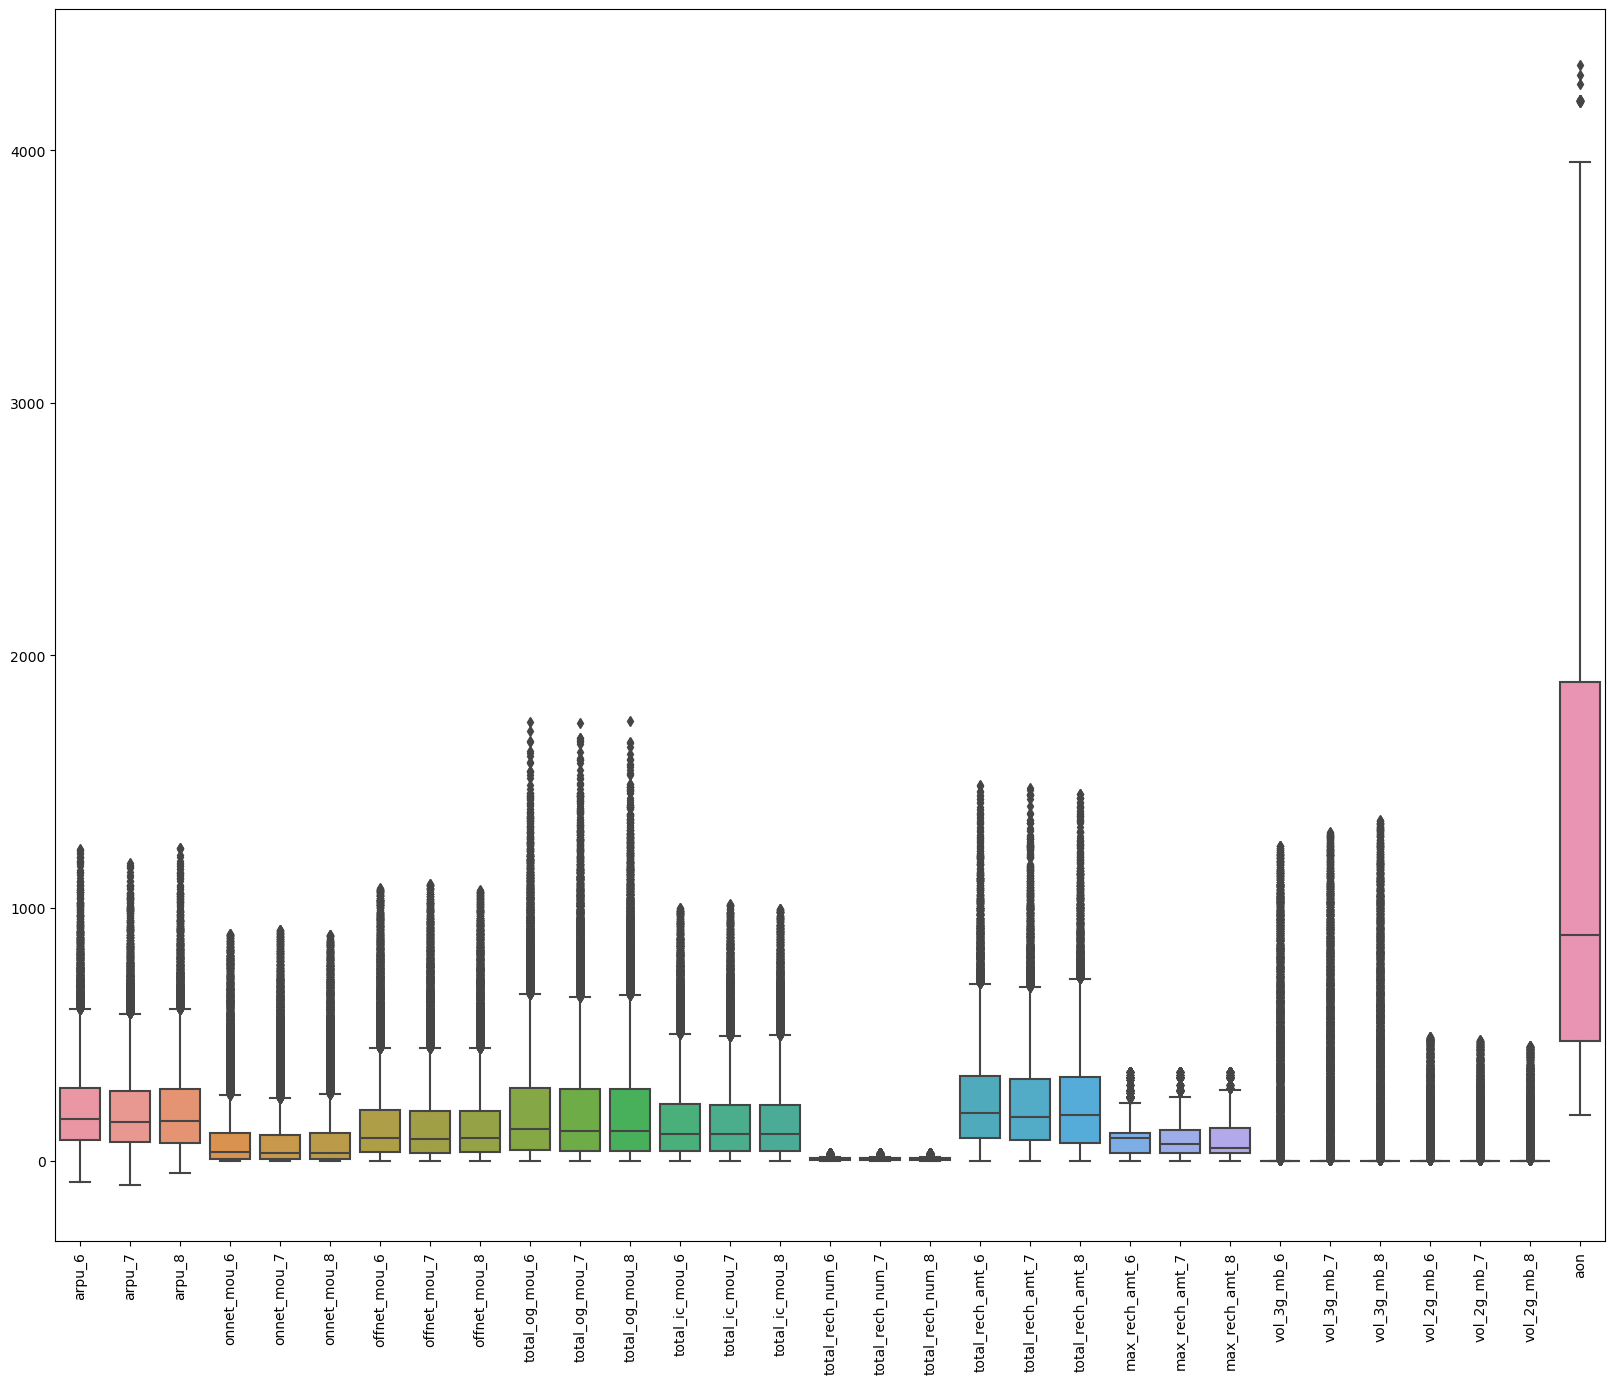

In [33]:
plt.figure(figsize=(20,16))
plt.xticks(rotation=90)
sns.boxplot(data = X_train)

We do not have much outliers as we have already removed using IQR method.

Visualizing data using Boxplot :: 

<Axes: xlabel='churn_probability', ylabel='aon'>

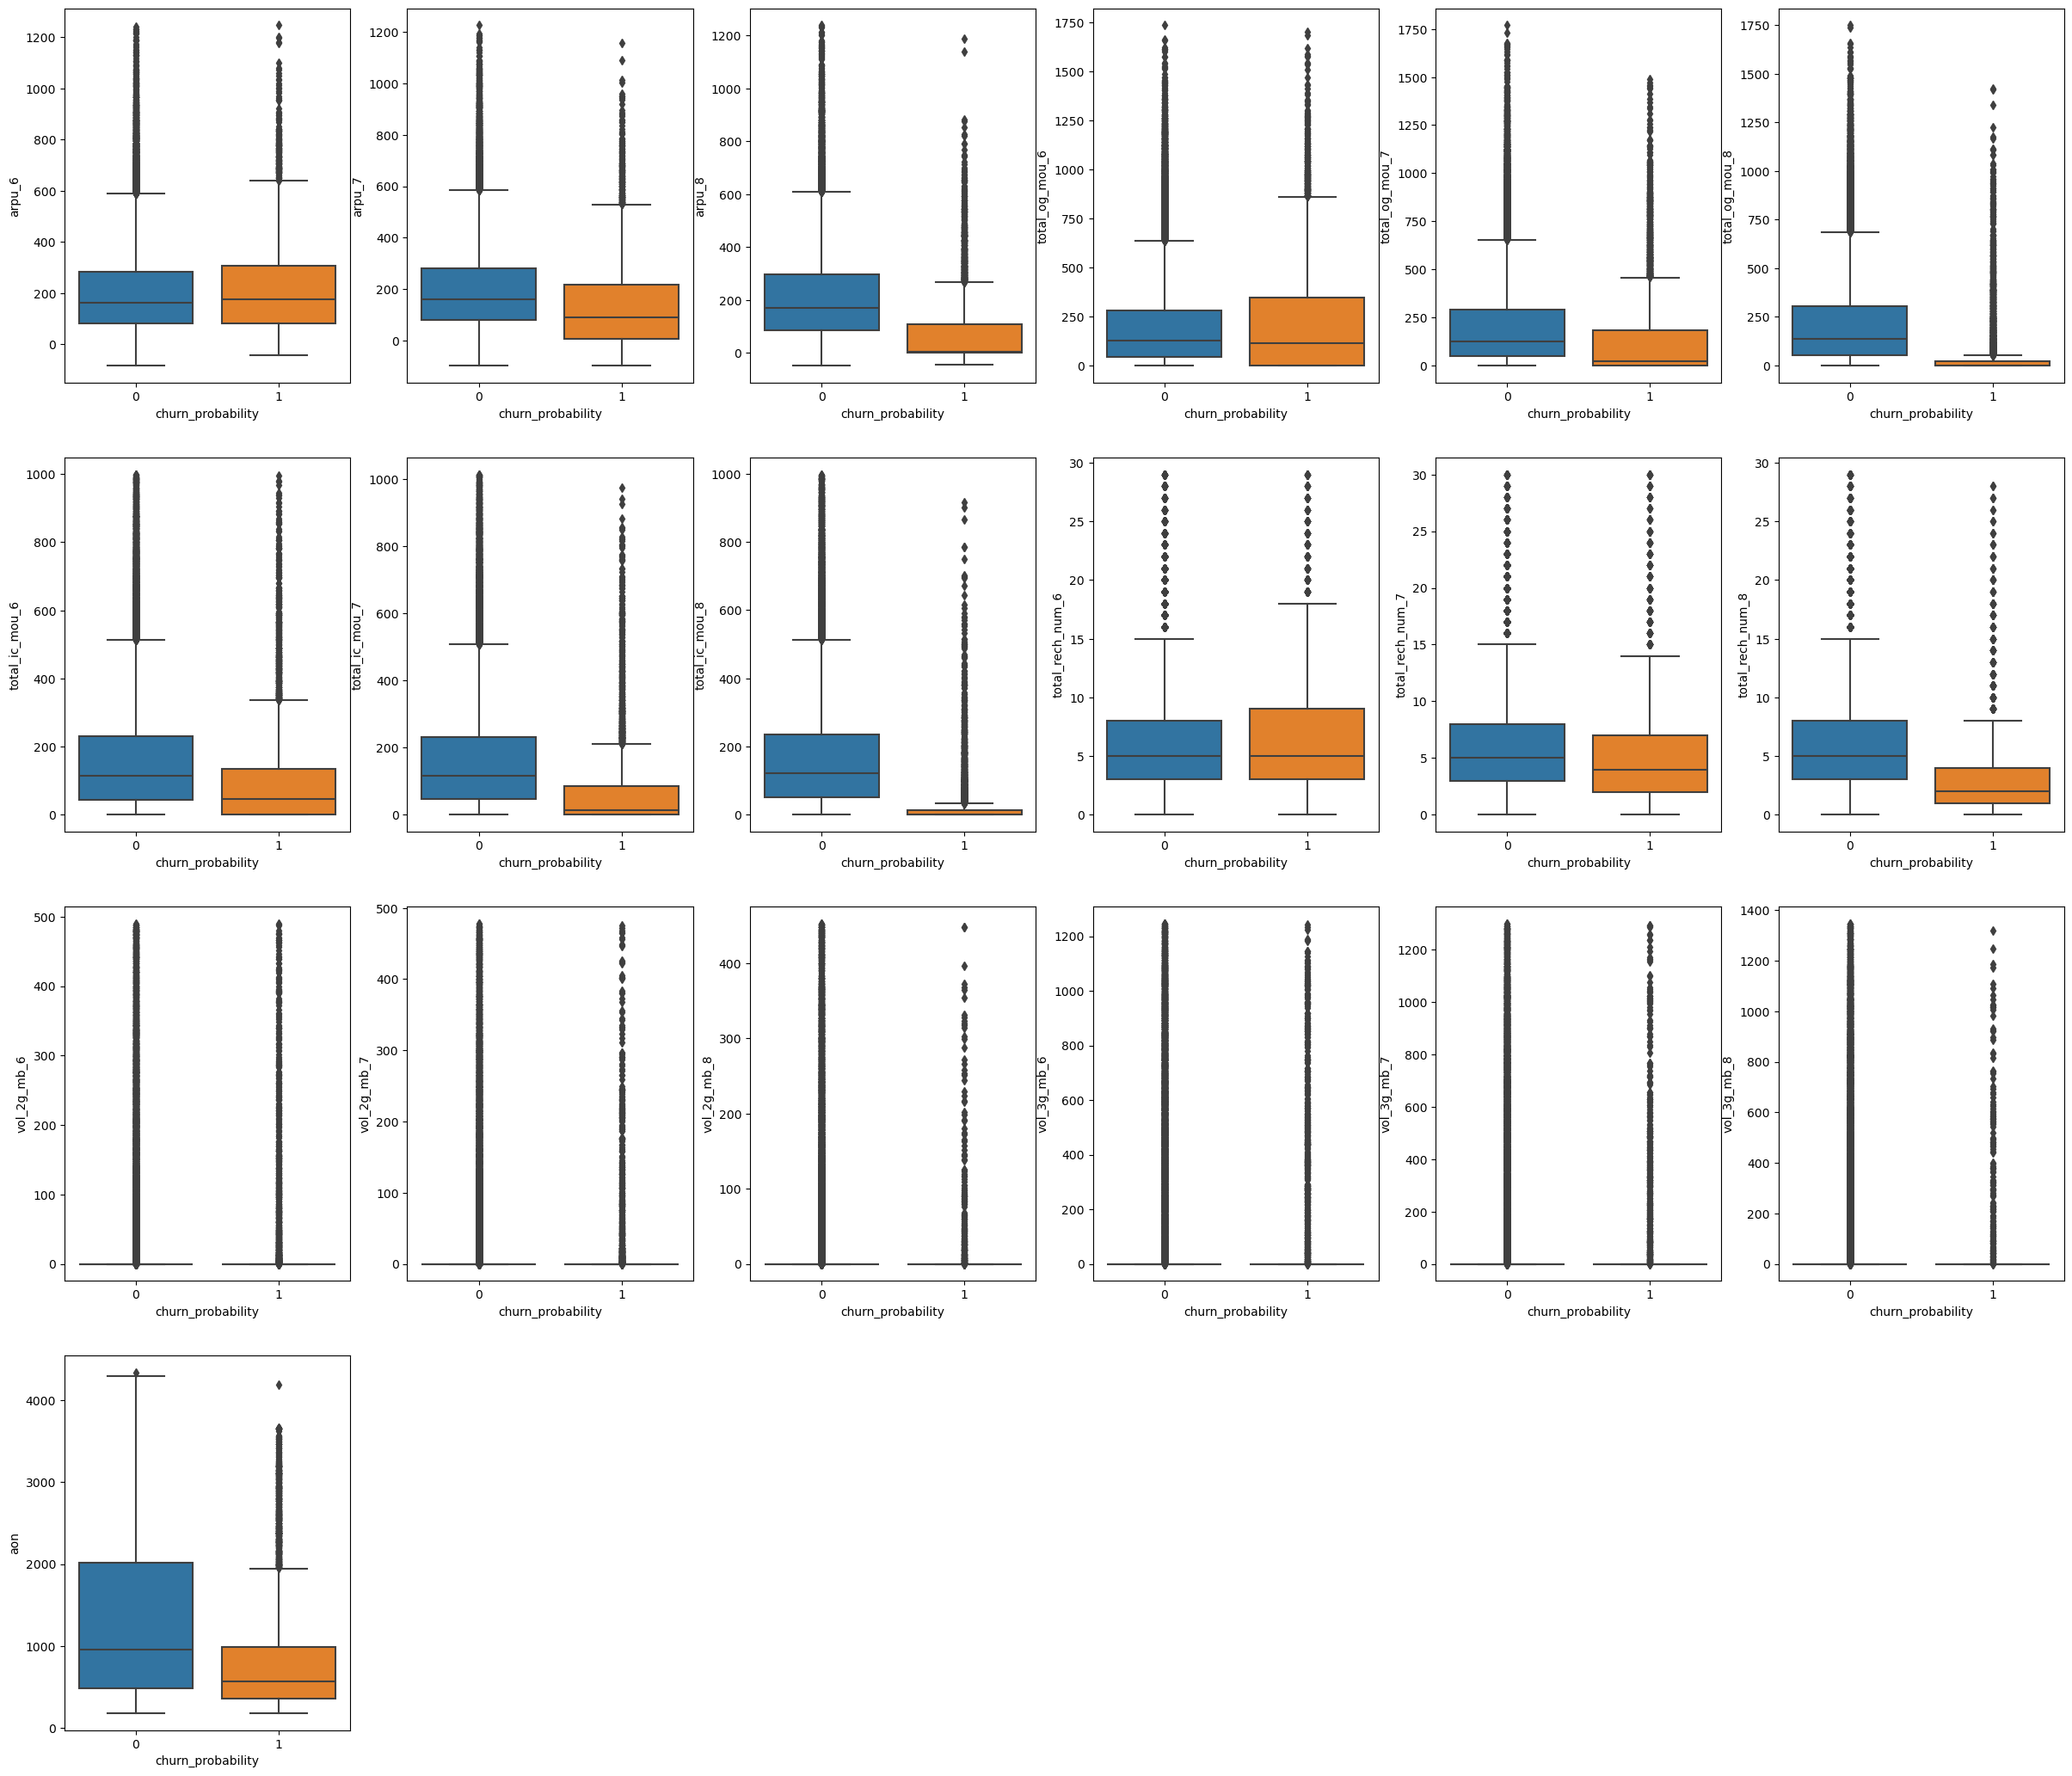

In [34]:
plt.figure(figsize=(30,26))
plt.subplot(4,6,1)
sns.boxplot(x='churn_probability', y='arpu_6', data=data_filtered)

plt.subplot(4,6,2)
sns.boxplot(x='churn_probability', y='arpu_7', data=data_filtered)

plt.subplot(4,6,3)
sns.boxplot(x='churn_probability', y='arpu_8', data=data_filtered)

plt.subplot(4,6,4)
sns.boxplot(x='churn_probability', y='total_og_mou_6', data=data_filtered)

plt.subplot(4,6,5)
sns.boxplot(x='churn_probability', y='total_og_mou_7', data=data_filtered)

plt.subplot(4,6,6)
sns.boxplot(x='churn_probability', y='total_og_mou_8', data=data_filtered)

plt.subplot(4,6,7)
sns.boxplot(x='churn_probability', y='total_ic_mou_6', data=data_filtered)

plt.subplot(4,6,8)
sns.boxplot(x='churn_probability', y='total_ic_mou_7', data=data_filtered)

plt.subplot(4,6,9)
sns.boxplot(x='churn_probability', y='total_ic_mou_8', data=data_filtered)

plt.subplot(4,6,10)
sns.boxplot(x='churn_probability', y='total_rech_num_6', data=data_filtered)

plt.subplot(4,6,11)
sns.boxplot(x='churn_probability', y='total_rech_num_7', data=data_filtered)

plt.subplot(4,6,12)
sns.boxplot(x='churn_probability', y='total_rech_num_8', data=data_filtered)

plt.subplot(4,6,13)
sns.boxplot(x='churn_probability', y='vol_2g_mb_6', data=data_filtered)

plt.subplot(4,6,14)
sns.boxplot(x='churn_probability', y='vol_2g_mb_7', data=data_filtered)

plt.subplot(4,6,15)
sns.boxplot(x='churn_probability', y='vol_2g_mb_8', data=data_filtered)

plt.subplot(4,6,16)
sns.boxplot(x='churn_probability', y='vol_3g_mb_6', data=data_filtered)

plt.subplot(4,6,17)
sns.boxplot(x='churn_probability', y='vol_3g_mb_7', data=data_filtered)

plt.subplot(4,6,18)
sns.boxplot(x='churn_probability', y='vol_3g_mb_8', data=data_filtered)

plt.subplot(4,6,19)
sns.boxplot(x='churn_probability', y='aon', data=data_filtered)




### Observations
1. Average revenue per user is decreasing for churned customers
2. Total incoming and outgoing call volumes are going down for customers who are optiong out
3. Churned customers are gradually doing less number of recharges
4. New customers are more likely to churn

Check correlations ::

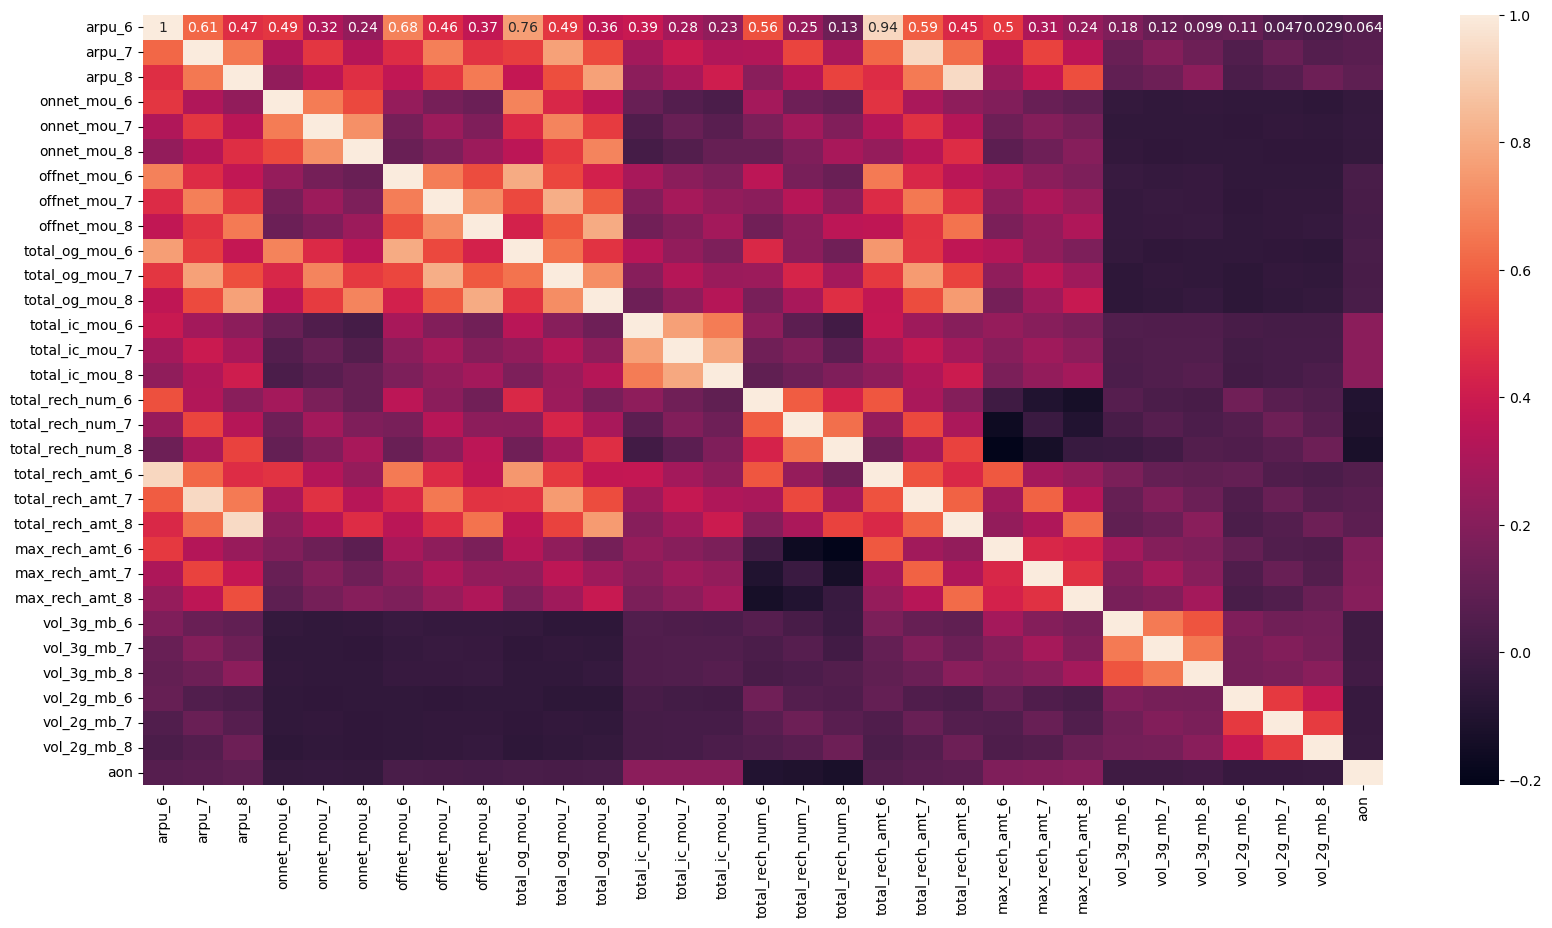

In [35]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(X_train.corr(),annot = True)
plt.show()

### 4.2 Scale Data

In [36]:
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

# Create a new DataFrame from the scaled data
#X_train_scaled = pd.DataFrame(scaled, columns=X_train.columns)

In [37]:
X_train.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,total_og_mou_6,...,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
49878,141.793,168.115,154.986,60.16,48.71,32.09,135.58,225.86,236.53,195.74,...,110,110,130,0.0,0.0,0.0,0.0,0.0,0.0,656
13314,385.536,424.320,445.279,103.79,139.64,99.33,228.29,252.88,276.09,332.09,...,60,50,50,0.0,0.0,0.0,0.0,0.0,0.0,727
47315,400.871,435.720,344.588,435.53,531.58,173.13,227.43,244.43,535.21,666.14,...,150,120,144,0.0,0.0,0.0,0.0,0.0,0.0,787
12849,779.438,315.564,387.878,110.59,11.81,67.91,382.39,145.13,211.73,248.14,...,250,250,250,0.0,0.0,0.0,0.0,0.0,0.0,1778
4127,117.897,305.135,119.631,30.93,125.53,143.84,87.04,346.89,107.46,115.68,...,67,110,65,0.0,0.0,0.0,0.0,0.0,0.0,626


<Axes: >

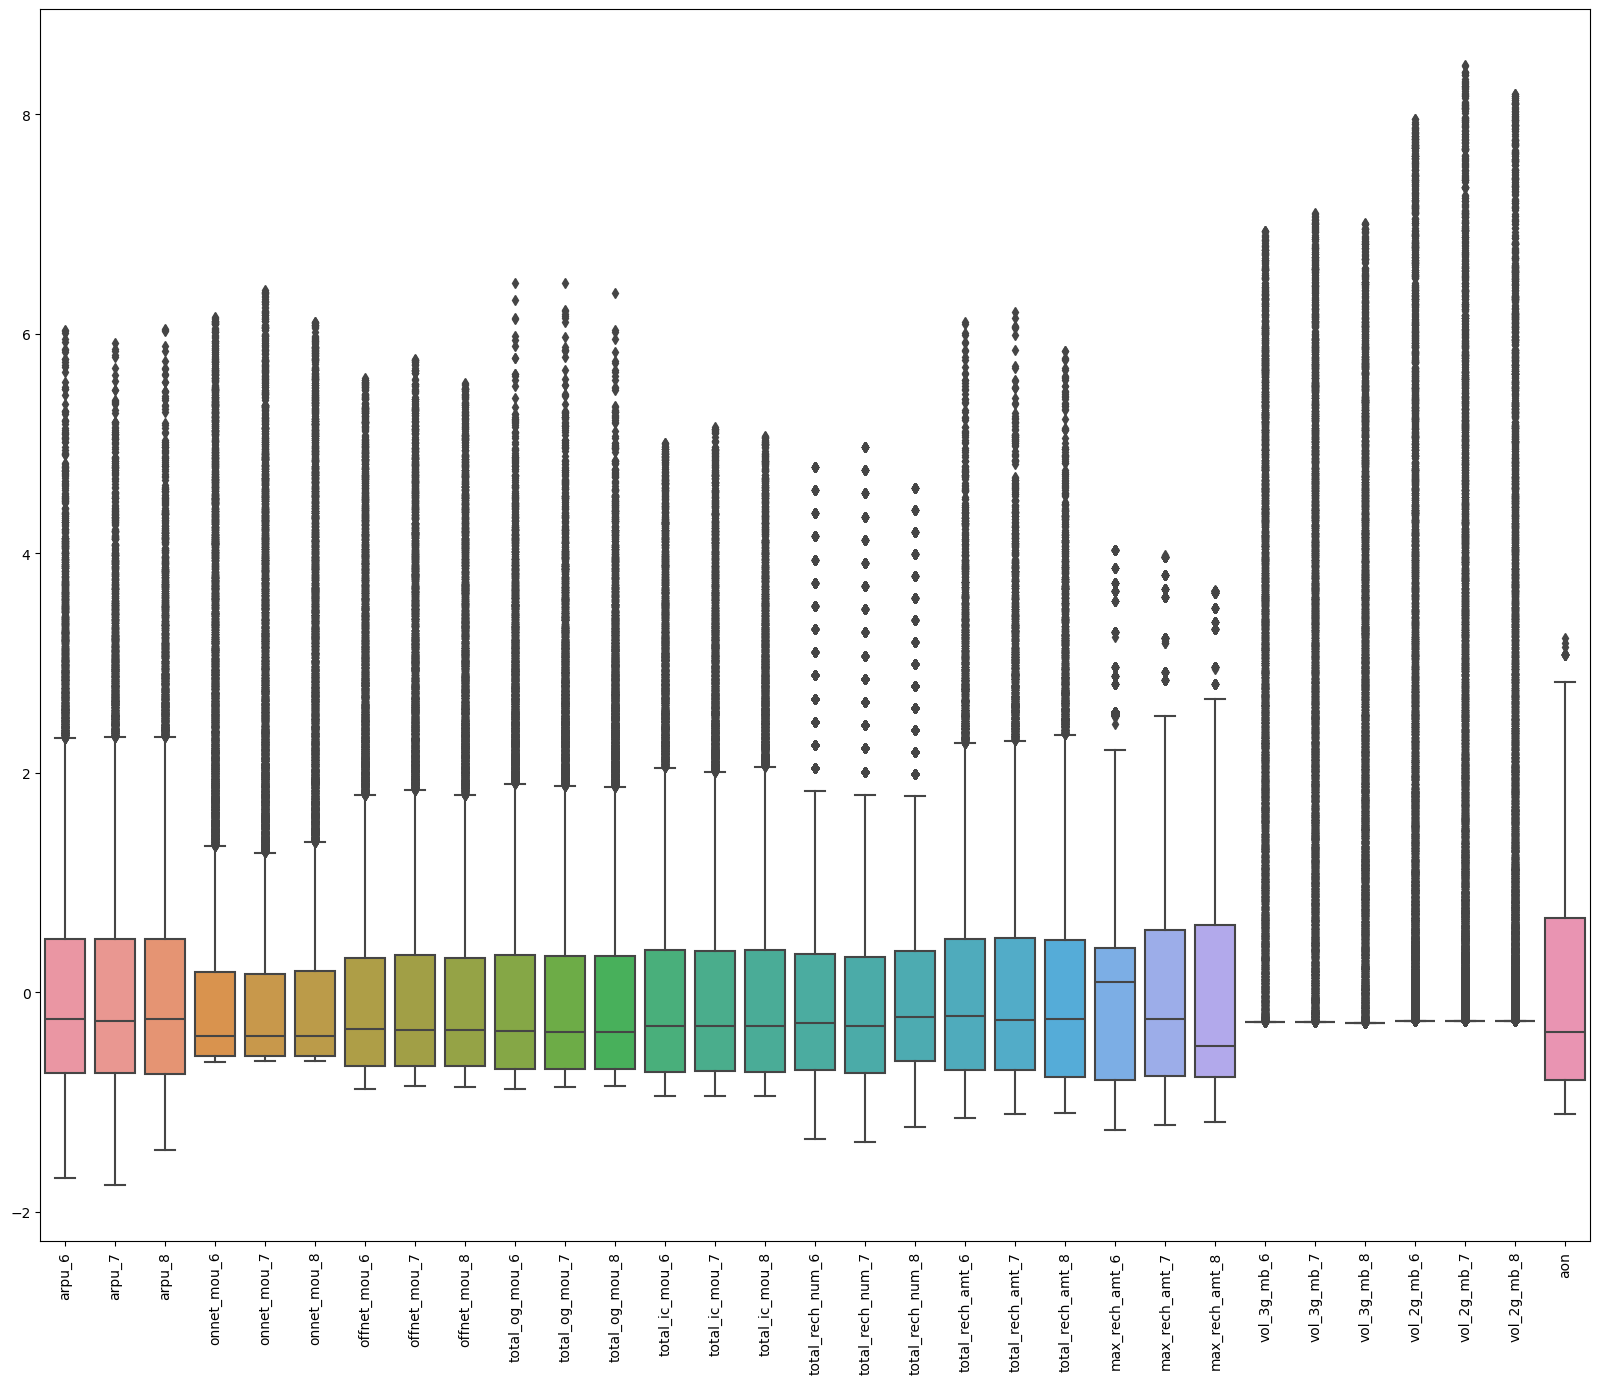

In [38]:
plt.figure(figsize=(20,16))
plt.xticks(rotation=90)
sns.boxplot(data = pd.DataFrame(X_train_scaled, columns = X_train.columns))

<Axes: xlabel='churn_probability', ylabel='Count'>

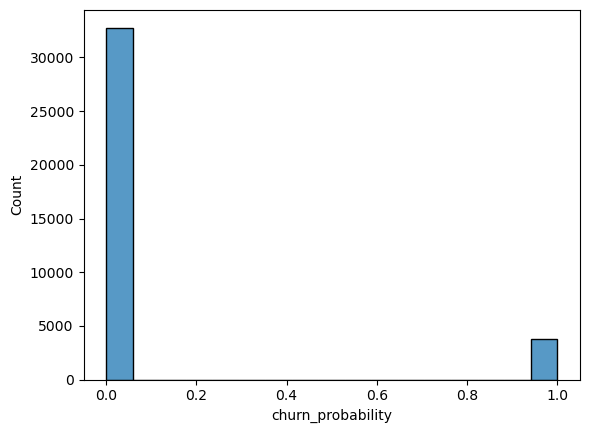

In [39]:
#Distribution for the churn probability
sns.histplot(y_train)

In [40]:
### Checking the Churn Rate
churn = (sum(data['churn_probability'])/len(data['churn_probability'].index))*100
churn

10.188716981671167

## 5. Model Building

### 5.1 Logistic Regression without using RFE

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg1 = LogisticRegression()

In [42]:
logreg1.fit(X_train_scaled, y_train)

LogisticRegression()

In [43]:
y_pred = logreg1.predict(X_test_scaled)
y_pred_prob = logreg1.predict_proba(X_test_scaled)

In [44]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob[:,1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.9307707018550392
Precision: 0.7953629032258065
Recall: 0.47188995215311
F1 Score: 0.5923423423423423
ROC AUC Score: 0.9101040921637276


In [45]:
confusion = metrics.confusion_matrix(y_test, y_pred )
confusion

array([[13812,   203],
       [  883,   789]])

### 5.2 Logistic Regression using RFE

In [46]:
from sklearn.feature_selection import RFE
logreg2 = LogisticRegression()
rfe = RFE(logreg2, n_features_to_select=20)             # running RFE with 20 variables as output
rfe = rfe.fit(X_train_scaled, y_train)

In [47]:
## View selected features
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', False, 8),
 ('arpu_7', True, 1),
 ('arpu_8', True, 1),
 ('onnet_mou_6', True, 1),
 ('onnet_mou_7', True, 1),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', True, 1),
 ('offnet_mou_7', True, 1),
 ('offnet_mou_8', True, 1),
 ('total_og_mou_6', True, 1),
 ('total_og_mou_7', True, 1),
 ('total_og_mou_8', True, 1),
 ('total_ic_mou_6', False, 6),
 ('total_ic_mou_7', True, 1),
 ('total_ic_mou_8', True, 1),
 ('total_rech_num_6', False, 7),
 ('total_rech_num_7', False, 2),
 ('total_rech_num_8', True, 1),
 ('total_rech_amt_6', False, 4),
 ('total_rech_amt_7', False, 3),
 ('total_rech_amt_8', True, 1),
 ('max_rech_amt_6', False, 5),
 ('max_rech_amt_7', True, 1),
 ('max_rech_amt_8', True, 1),
 ('vol_3g_mb_6', False, 9),
 ('vol_3g_mb_7', False, 12),
 ('vol_3g_mb_8', True, 1),
 ('vol_2g_mb_6', False, 10),
 ('vol_2g_mb_7', False, 11),
 ('vol_2g_mb_8', True, 1),
 ('aon', True, 1)]

In [48]:
rfe_selected_col = X_train.columns[rfe.support_]
rfe_selected_col

Index(['arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_7', 'total_ic_mou_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_7',
       'max_rech_amt_8', 'vol_3g_mb_8', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [49]:
## Train the logistic regression model using the selected features
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

In [50]:
## Train the model
logreg2.fit(X_train_rfe, y_train)

LogisticRegression()

In [51]:
## Make predictions
y_pred_rfe = logreg2.predict(X_test_rfe)
y_pred_prob_rfe = logreg2.predict_proba(X_test_rfe)
y_pred_rfe[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [52]:
accuracy = accuracy_score(y_test, y_pred_rfe)
precision = precision_score(y_test, y_pred_rfe)
recall = recall_score(y_test, y_pred_rfe)
f1 = f1_score(y_test, y_pred_rfe)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_rfe[:,1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.9309619430101358
Precision: 0.7959798994974875
Recall: 0.47368421052631576
F1 Score: 0.59392575928009
ROC AUC Score: 0.9100448169852192


In [53]:
confusion = metrics.confusion_matrix(y_test, y_pred_rfe )
confusion

array([[13812,   203],
       [  880,   792]])

Not seeing any improvement in accuracy. Checking VIFs

In [54]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [55]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_selected_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_selected_col].values, i) for i in range(X_train[rfe_selected_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,total_og_mou_7,31.65
14,total_rech_amt_8,30.40
1,arpu_8,29.26
10,total_og_mou_8,25.98
8,total_og_mou_6,21.40
6,offnet_mou_7,16.94
7,offnet_mou_8,13.02
5,offnet_mou_6,12.73
0,arpu_7,10.86
3,onnet_mou_7,9.95


There are multiple variables with very high VIF. High VIF variables should not help much with prediction. Lets start dropping and check accuracy.

In [56]:
logreg3 = LogisticRegression()
rfe2 = RFE(logreg3, n_features_to_select=10)             # running RFE with 10 variables as output
rfe2 = rfe2.fit(X_train_scaled, y_train)

In [57]:
## Train the logistic regression model using the selected features
X_train_rfe2 = rfe2.transform(X_train_scaled)
X_test_rfe2 = rfe2.transform(X_test_scaled)

In [58]:
## Train the model
logreg3.fit(X_train_rfe2, y_train)

LogisticRegression()

In [59]:
## Make predictions
y_pred_rfe2 = logreg3.predict(X_test_rfe2)
y_pred_prob_rfe2 = logreg3.predict_proba(X_test_rfe2)
y_pred_rfe2[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [60]:
accuracy = accuracy_score(y_test, y_pred_rfe2)
precision = precision_score(y_test, y_pred_rfe2)
recall = recall_score(y_test, y_pred_rfe2)
f1 = f1_score(y_test, y_pred_rfe2)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_rfe2[:,1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.9310894371135335
Precision: 0.803076923076923
Recall: 0.46830143540669855
F1 Score: 0.5916131469588213
ROC AUC Score: 0.9080641341215069


In [61]:
confusion = metrics.confusion_matrix(y_test, y_pred_rfe2 )
confusion

array([[13823,   192],
       [  889,   783]])

In [62]:
rfe_selected_col = X_train.columns[rfe2.support_]
rfe_selected_col

Index(['onnet_mou_6', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_8',
       'total_og_mou_6', 'total_og_mou_8', 'total_ic_mou_7', 'total_ic_mou_8',
       'total_rech_amt_8', 'vol_3g_mb_8'],
      dtype='object')

In [63]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_selected_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_selected_col].values, i) for i in range(X_train[rfe_selected_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,total_og_mou_8,18.62
4,total_og_mou_6,18.30
2,offnet_mou_6,10.64
3,offnet_mou_8,9.99
0,onnet_mou_6,6.12
1,onnet_mou_8,5.81
8,total_rech_amt_8,5.78
7,total_ic_mou_8,5.68
6,total_ic_mou_7,5.19
9,vol_3g_mb_8,1.24


Getting highest accuracy using RFE selected Logistic Regression model :: logreg2. Lets calculate sensitivity and specificity of this model.

Getting decent Precision and excellent ROC score. Accuracy = 0.93

### 5.3 RandomForest

In [64]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [65]:
## make prediction
y_pred_randomforest = rf.predict(X_test)
y_pred_prob_randomforest = rf.predict_proba(X_test)

In [66]:
accuracy = accuracy_score(y_test, y_pred_randomforest)
precision = precision_score(y_test, y_pred_randomforest)
recall = recall_score(y_test, y_pred_randomforest)
f1 = f1_score(y_test, y_pred_randomforest)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_randomforest[:,1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')


Accuracy: 0.8928412060942181
Precision: 0.40816326530612246
Recall: 0.011961722488038277
F1 Score: 0.023242300987797792
ROC AUC Score: 0.7361422186071996


In [67]:
confusion = metrics.confusion_matrix(y_test, y_pred_randomforest )
confusion

array([[13986,    29],
       [ 1652,    20]])

Though getting decent accuracy score, Precision, Recall and F1 scores are very low. Getting AUC score > 0.7 which is decent for this kind of imbalanced data.

In [68]:
## Lets plot the important variables as per RandomForest 
feature_importances = pd.DataFrame({'col':X_train.columns, 'importance':rf.feature_importances_})

<BarContainer object of 31 artists>

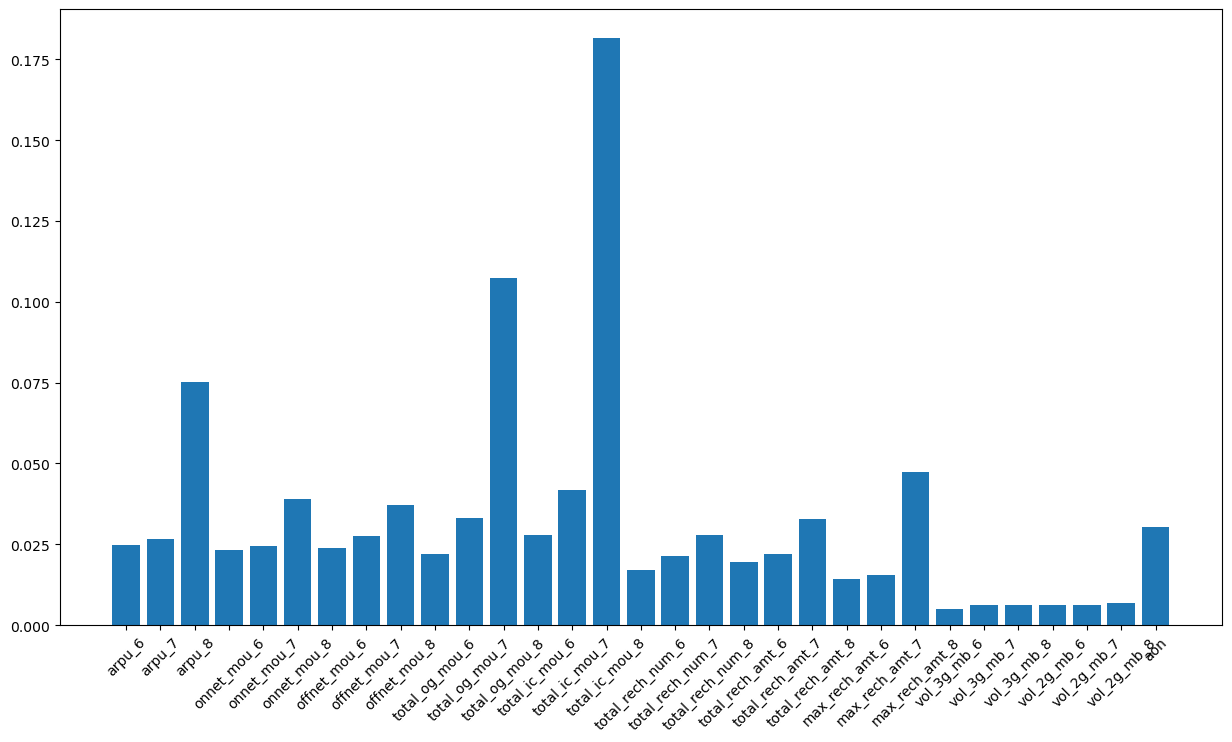

In [69]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

### 5.4 Logistic Regression using PCA

In [70]:
pca = PCA(random_state=42)

In [71]:
pca.fit(X_train_scaled)

PCA(random_state=42)

In [72]:
pca.components_

array([[ 2.44414719e-01,  2.76164645e-01,  2.57408994e-01,
         1.57150986e-01,  1.78895797e-01,  1.63673661e-01,
         2.11156537e-01,  2.34638691e-01,  2.17855973e-01,
         2.38477782e-01,  2.69059255e-01,  2.49256001e-01,
         1.29948584e-01,  1.46014909e-01,  1.42783741e-01,
         1.36503454e-01,  1.45237635e-01,  1.27158364e-01,
         2.43525463e-01,  2.70484091e-01,  2.48930204e-01,
         1.32015229e-01,  1.51352720e-01,  1.46372158e-01,
         3.20472918e-02,  3.68503335e-02,  3.73169317e-02,
         8.68103810e-03,  1.44429297e-02,  1.36930289e-02,
         2.85766483e-02],
       [ 5.03410497e-02,  5.12728436e-02,  5.43632572e-02,
        -1.68873574e-01, -1.86657187e-01, -1.85412158e-01,
        -6.57011794e-02, -7.92743508e-02, -8.10760428e-02,
        -1.25723332e-01, -1.44515334e-01, -1.42505667e-01,
         1.41819508e-01,  1.39434825e-01,  1.36548091e-01,
        -7.89529829e-02, -1.00848441e-01, -1.24734638e-01,
         4.82086424e-02,  4.99

In [73]:
pca.explained_variance_ratio_

array([0.31194147, 0.10498811, 0.0814111 , 0.0760327 , 0.06848045,
       0.05212974, 0.04776204, 0.04136425, 0.02916658, 0.02363936,
       0.02173649, 0.01711309, 0.01589887, 0.01363621, 0.01195894,
       0.01119934, 0.01102687, 0.0095507 , 0.00912392, 0.00828322,
       0.00661488, 0.00568574, 0.00492147, 0.00388223, 0.00316327,
       0.00292075, 0.00176935, 0.00154932, 0.00120977, 0.00106029,
       0.00077948])

#### Creating scree plot to determine number of variables for PCA

In [74]:
varCumulativeSum = np.cumsum(pca.explained_variance_ratio_)

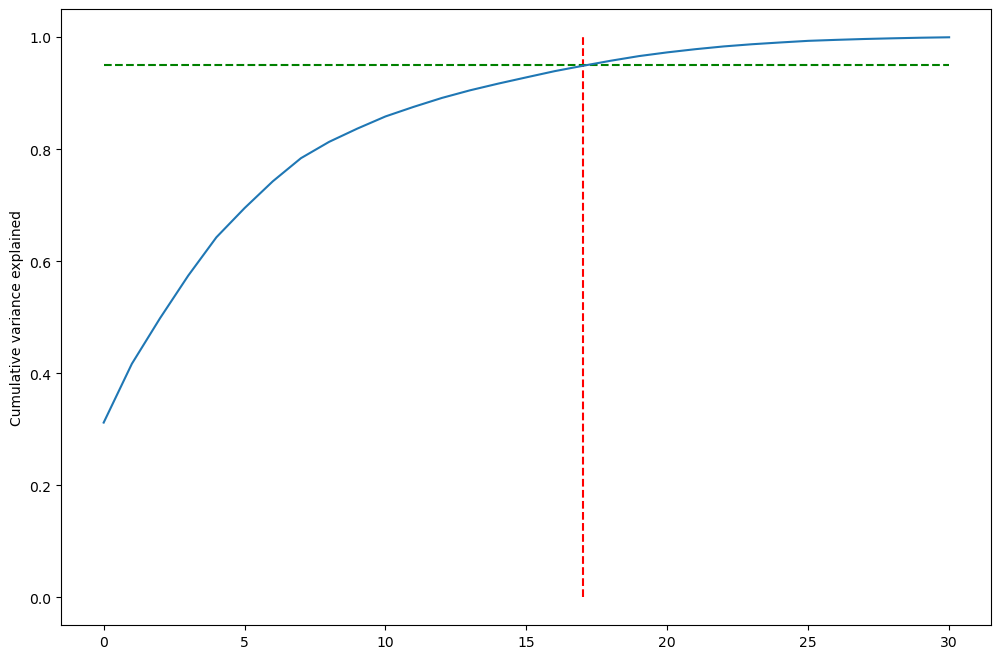

In [75]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=17, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(varCumulativeSum)
plt.ylabel("Cumulative variance explained")
plt.show()

About 95% variance is explained by 17 variables. So we will go-ahead with 17 variables.

In [76]:
### Perform PCA with 17 components
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=17)

In [77]:
df_train_pca = pca_final.fit_transform(X_train_scaled)
df_test_pca = pca_final.transform(X_test)

In [78]:
df_train_pca.shape

(36602, 17)

In [79]:
# putting correlation matrix for df_train_pca
correlation_matrix = np.corrcoef(df_train_pca.transpose())

In [80]:
correlation_matrix.shape

(17, 17)

<Axes: >

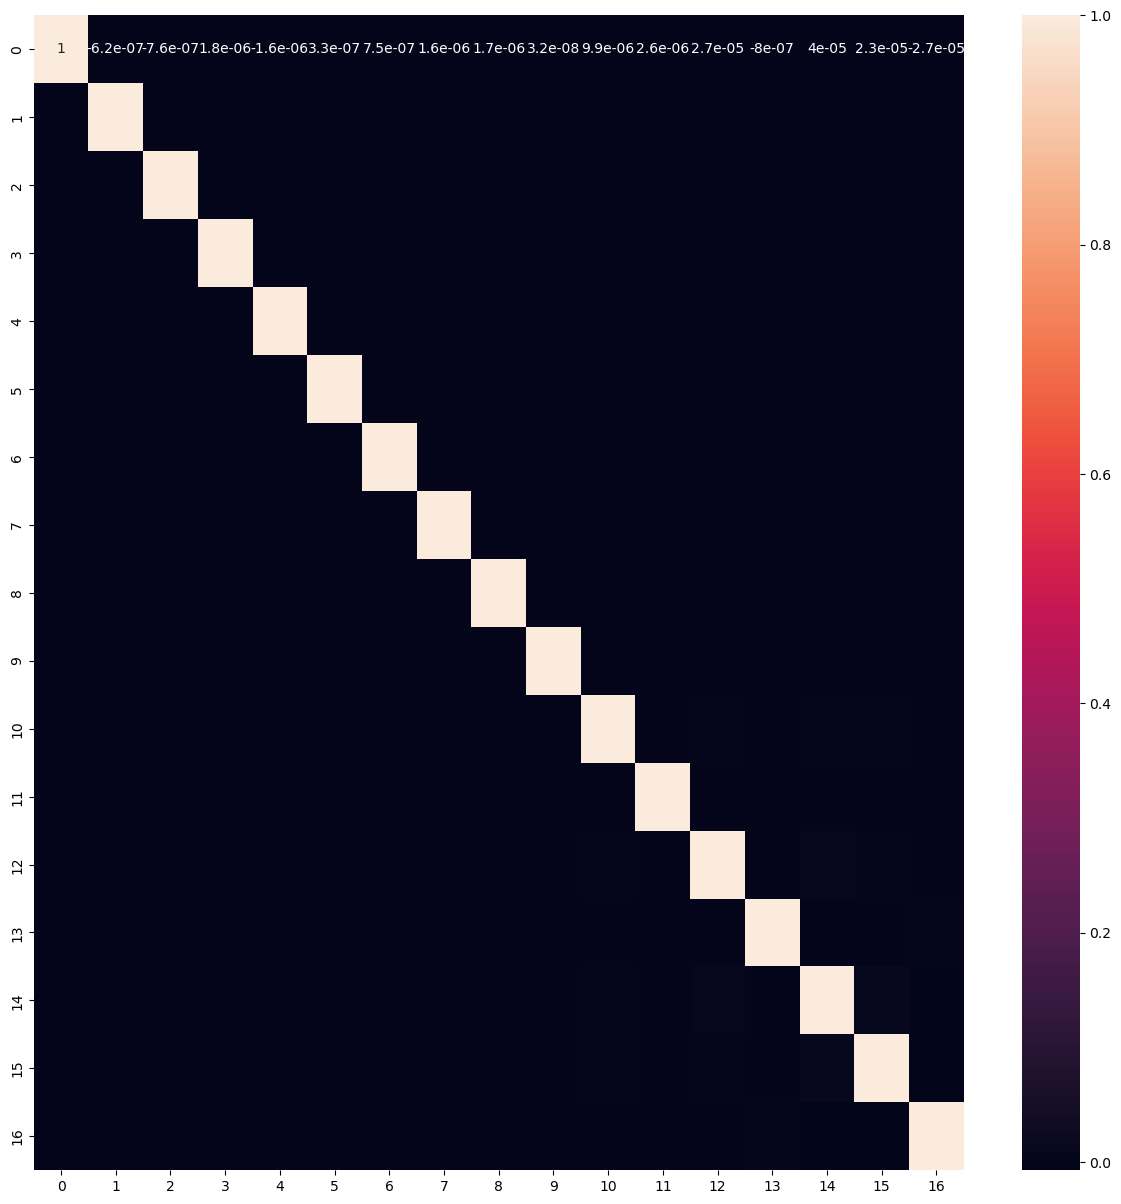

In [81]:
plt.figure(figsize=[15,15])
sns.heatmap(correlation_matrix, annot=True)

#### Applying Logistic Regression on the Principal Components

In [82]:
logistic_pca = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')

In [83]:
model_pca = logistic_pca.fit(df_train_pca, y_train)

In [84]:
## Make predictions using model
y_pred_pca = model_pca.predict(df_test_pca)
y_pred_prob_pca = model_pca.predict_proba(df_test_pca)

In [85]:
accuracy = accuracy_score(y_test, y_pred_pca)
precision = precision_score(y_test, y_pred_pca)
recall = recall_score(y_test, y_pred_pca)
f1 = f1_score(y_test, y_pred_pca)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_pca[:,1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')


Accuracy: 0.8888251418371901
Precision: 0.4608695652173913
Recall: 0.2535885167464115
F1 Score: 0.3271604938271605
ROC AUC Score: 0.7896420999714933


In [86]:
confusion = metrics.confusion_matrix(y_test, y_pred_pca )
confusion

array([[13519,   496],
       [ 1248,   424]])

### 5.5 Logistic Regression using Unsupervised PCA

In [87]:
pca_unsupervised = PCA(0.9)

In [88]:
df_train_pca_unsupervised = pca_unsupervised.fit_transform(X_train_scaled)

In [89]:
df_train_pca_unsupervised.shape

(36602, 14)

In [90]:
logistic_pca_unsupervised = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')

In [91]:
## Fit the model
model_pca_unsupervised = logistic_pca_unsupervised.fit(df_train_pca_unsupervised, y_train)

In [92]:
df_test_pca_unsupervised = pca_unsupervised.transform(X_test)
df_test_pca_unsupervised.shape

(15687, 14)

In [93]:
## Make predictions
y_pred_prob_pca_unsupervised = model_pca_unsupervised.predict_proba(df_test_pca_unsupervised)
y_pred_pca_unsupervised = model_pca_unsupervised.predict(df_test_pca_unsupervised)

In [94]:
accuracy = accuracy_score(y_test, y_pred_pca_unsupervised)
precision = precision_score(y_test, y_pred_pca_unsupervised)
recall = recall_score(y_test, y_pred_pca_unsupervised)
f1 = f1_score(y_test, y_pred_pca_unsupervised)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_pca_unsupervised[:,1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.9001721170395869
Precision: 0.6345177664974619
Recall: 0.14952153110047847
F1 Score: 0.24201355275895448
ROC AUC Score: 0.8026775609522948


### 5.6 Logistic Regression using SMOTE

We have only 10% churn rate in the given dataset. So data is highly imbalanced. Applying Synthetic Minority Over-sampling Technique.

In [95]:
from imblearn.over_sampling import SMOTE

In [98]:
smote = SMOTE(random_state=42)

In [99]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [100]:
## Scale the data
scaler4 = StandardScaler()
X_train_smote_scaled = scaler4.fit_transform(X_train_smote)
X_test_smote_scaled = scaler4.transform(X_test)


In [101]:
## Create Logistic Regression model
lr_smote = LogisticRegression()

In [102]:
## Train the model
lr_smote.fit(X_train_smote_scaled, y_train_smote)

LogisticRegression()

In [103]:
## Make predictions
y_pred_smote = lr_smote.predict(X_test_smote_scaled)
y_pred_prob_smote = lr_smote.predict_proba(X_test_smote_scaled)[:,1]

In [104]:
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_smote)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.8573340982979537
Precision: 0.41470765521398434
Recall: 0.8229665071770335
F1 Score: 0.5515030060120241
ROC AUC Score: 0.9075842782937625


LG with GridSearchCV and StratifiedKFold

In [118]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline

In [127]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [128]:
param_grid = {
    'logreg__C': [.01,.1,1,10,100],
    'logreg__penalty': ['l1','l2'],
    'logreg__solver': ['liblinear']
}

In [129]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [130]:
grid_search = GridSearchCV(pipeline,param_grid,cv=kfold, scoring={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)},
                           refit='accuracy', verbose=1)

In [131]:
grid_search.fit(X,y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.01, 0.1, 1, 10, 100],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear']},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)},
             verbose=1)

In [132]:
model = grid_search.best_estimator_

In [133]:
y_pred_grid = model.predict(X)

In [134]:
accuracy = accuracy_score(y, y_pred_grid)
accuracy

0.8606016561800761

RandomClassifier with GridSearchCV and StratifiedKFold

In [142]:
random_classifier_gs = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

In [143]:
param_grid = {
    'max_depth': [5,10,15,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'bootstrap': [True, False]
}

In [144]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [145]:
grid_search = GridSearchCV(estimator=random_classifier_gs,param_grid=param_grid,cv=kfold, scoring={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)},
                           refit='accuracy', verbose=1, n_jobs=-1)

In [146]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)},
             verbose=1)

In [147]:
model = grid_search.best_estimator_

In [148]:
y_pred_rf_grid = model.predict(X_test)

In [177]:
accuracy = accuracy_score(y_test, y_pred_rf_grid)
accuracy

ValueError: Found input variables with inconsistent numbers of samples: [15687, 30000]

### Submission File

In [162]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [163]:
unseen_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00,0
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00,0
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84,0
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00,0
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00,0


In [164]:
unseen_data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,30000.000000,30000.0,29684.0,29684.0,29684.0,30000.000000,30000.000000,30000.000000,28831.000000,28828.000000,...,30000.000000,30000.000000,7585.000000,7706.000000,7922.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0
mean,84998.500000,109.0,0.0,0.0,0.0,282.644348,279.355021,279.845167,130.629693,133.148632,...,0.077967,0.082200,0.909954,0.906956,0.891946,1218.023200,68.314097,68.946576,59.891621,0.0
std,8660.398374,0.0,0.0,0.0,0.0,314.560212,323.205370,326.437029,290.677420,302.921820,...,0.613596,0.611546,0.286267,0.290513,0.310468,960.109844,263.460641,278.749349,246.098292,0.0
min,69999.000000,109.0,0.0,0.0,0.0,-185.043000,-2014.045000,-146.859000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.0
25%,77498.750000,109.0,0.0,0.0,0.0,92.907500,87.504750,84.180500,7.280000,6.660000,...,0.000000,0.000000,1.000000,1.000000,1.000000,466.000000,0.000000,0.000000,0.000000,0.0
50%,84998.500000,109.0,0.0,0.0,0.0,198.227500,191.775000,191.690500,34.760000,32.550000,...,0.000000,0.000000,1.000000,1.000000,1.000000,853.000000,0.000000,0.000000,0.000000,0.0
75%,92498.250000,109.0,0.0,0.0,0.0,371.969250,365.250750,367.804750,117.170000,115.210000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1795.000000,0.000000,0.000000,0.000000,0.0
max,99998.000000,109.0,0.0,0.0,0.0,10955.066000,13224.119000,13505.996000,6944.360000,7411.010000,...,35.000000,30.000000,1.000000,1.000000,1.000000,4197.000000,6054.390000,7994.840000,6614.530000,0.0


In [165]:
unseen_data['churn_probability'] = 0

In [166]:
submission_data = unseen_data.set_index('id')[X_test.columns]

In [167]:
submission_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,total_og_mou_6,...,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,91.94,...,50,30,30,0.0,0.0,0.0,0.0,0.0,0.0,1692
70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,549.86,...,250,250,250,0.0,0.0,0.0,0.0,0.0,0.0,2533
70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,0.00,...,300,500,500,0.0,0.0,0.0,0.0,0.0,0.0,277
70002,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,45.36,...,110,150,0,0.0,0.0,0.0,0.0,0.0,0.0,1244
70003,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,74.16,514.79,...,90,130,130,0.0,0.0,0.0,0.0,0.0,0.0,462


In [168]:
missing_data_percent_2 = submission_data.isnull().any()
impute_cols_unseen = missing_data_percent_2[missing_data_percent_2.gt(0)].index
impute_cols_unseen

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8'],
      dtype='object')

In [169]:
imp_2 = SimpleImputer(strategy='constant', fill_value=0)
submission_data[impute_cols_unseen] = imp_2.fit_transform(submission_data[impute_cols_unseen])

In [170]:
X_test.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6',
       'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_num_6',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [171]:
submission_data.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6',
       'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_num_6',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [161]:
############### Working version with PCA Unsupervised ####################
#df_unseen_pca_unsupervised = pca_unsupervised.transform(submission_data)
#df_unseen_pca_unsupervised.shape
#unseen_data['churn_probability'] = model_pca_unsupervised.predict(df_unseen_pca_unsupervised)

In [279]:
#logreg2
submission_data_scaled = scale.transform(submission_data)
submission_data_scaled = rfe.transform(submission_data_scaled)
unseen_data['churn_probability'] = logreg2.predict(submission_data_scaled)

In [287]:
# smot
submission_data_smot_scaled = scaler4.transform(submission_data)
unseen_data['churn_probability'] = lr_smote.predict(submission_data_smot_scaled)

In [174]:
# RandomForest with Gridsearch
y_pred_rf_grid = model.predict(submission_data)
unseen_data['churn_probability'] = model.predict(submission_data)

In [175]:
output = unseen_data[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


In [176]:
output.to_csv('Submission.csv',index=False)